# Tratamiento de imágenes - 2025 - Entregable 2

# Fecha de entrega: 18/05/2025

### Importante:   
En todos los ejercicios se espera que se entregue comentarios sobre decisiones tomadas en la implementación así como un análisis de los resultados. Estos comentarios y análisis se pueden entregar en celdas de texto agregadas a los notebooks o en un informe aparte.

Para la entrega se sube un **zip** (no rar, ni otro formato) con:
* El notebook del entregable modificado. El notebook debe tener las celdas ejecutadas con las salidas correspondientes. Debe tener todo lo necesario para poder ser ejecutado nuevamente
* Todo el resto del contenido del zip del entregable. Si, para mostrar resultados, usan en el notebook imágenes propias, deben incluirlas en la carpeta **imagenes**  del zip.
* El informe en pdf en caso de no incluir las discusiones dentro del notebook en celdas "Markdown", o si les resulta más sencillo realizar el análisis en un documento aparte.

No se deben incluir en el zip de la entrega las imágenes de prueba que están disponibles en la página web del curso. Se asumirá que esas imágenes están en un directorio y se hará referencia a dichas imágenes en forma relativa a ese directorio (ver la celda siguiente).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import math
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
from skimage import transform, io, restoration
from skimage.transform import hough_line, hough_line_peaks
from scipy.signal import convolve2d

# FORMAS DE VER LAS GRAFICAS --------------------
# ELEGIR UNA DE LAS OPCIONES Y DES-COMENTAR (sacar # de la linea)
# ----------------
# a) graficas en línea  entre las celdas (no interactivo)
%matplotlib inline
# ----------------
# b) graficas en línea  entre las celdas (interactivo)
# %matplotlib notebook
# ----------------
# c) graficas en ventanas externas (abre una ventana por cada figura)
# %matplotlib
# ----------------
# d) Si se usa "jupyter lab" en lugar de "jupyter notebook" usar %matplotlib widget en lugar de %matplotlib notebook
# requiere instalar el modulo "ipympl". Ver https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab#56416229
# %matplotlib widget
#---------------------------------------------------



# Directorio con la base de imágenes de prueba (las que están en la web de Timag)
# Ej. si usan la imagen trapo.jpg en el notebook no tienen que subirla al eva
# La llaman en el notebook en forma relativa a donde tengan esas imagenes:
#
# filename = os.path.join(dir_base_imagenes, 'trapo.jpg')
# I = imread(filename)
dir_base_imagenes = '/content/drive/MyDrive/timag/entregable_2/imagenes'


## 1. FFT - Visualización en espacio y frecuencia

_Nota:    
Mostrar imágenes representativas de los procedimientos realizados.   
Se recomienda usar Fiji para esta tarea._




 1. Visualizar la imagen [trapo.jpg](./imagenes/trapo.jpg) y graficar varios perfiles (horizontal y vertical) del trapo de la imagen. Medir el periodo en píxeles de la onda en cada dirección. No es necesaria una medida exhaustiva.

_Respuesta:_

Para el periodo horizontal (162px-112px)=50

$T_x = 50 ~\text{px}$ (período horizontal)

Para el periodo vertical (10px-4px)=

$T_y = 6  ~\text{px}$ (período vertical)

2. Calcular la transformada de Fourier de la imagen e identificar visualmente los picos espectrales. Indicar en qué coordenadas respecto al centro del espectro ocurre estos picos. Ver a que frecuencia correponden.


_Se recomienda usar la herramienta **'Rectangle'** de FIJI para esto y ver el width y height del rectangulo a trazar_



_Respuesta:_

$f_x =$ 10px  (frecuencia horizontal)   

$f_y =$ 85px   (frecuencia vertical)

3. Discutir la relación entre las medidas realizadas en el espacio en (a) y la ubicación de los picos en frecuencia en (b).

_Respuesta:_

Cuando medí el trapo en el dominio espacial, vi que las franjas horizontales eran muy anchas (unos 50 px) y las verticales muy juntas (unos 6 px). Al mirar la FFT, las manchas que reflejan esas franjas verticales se ven alejadas del centro, mientras que las correspondientes a las franjas horizontales quedan casi pegadas.
Lo anterior indica que los patrones gruesos aparecen cerca del centro del espectro y los finos, más lejos.

4. **_(Opcional)_** Proponer e implementar un filtrado en frecuencia que haga desaparecer las rayas del trapo (quede aproximadamente liso) sin modificar sustancialmente el resto de la imagen.

Mostrar el filtro frecuencial, la FFT filtrada y su antitransformada



## 2. Restauración de imágenes con Movimiento Lineal Uniforme (MLU)

**1. Ver PSF y MTF del movimiento lineal uniforme (se provee una función que genera una PSF a partir del largo y el ángulo del movimiento)**

Imagen sugerida: cameraman

Para un cierto movimiento lineal:
* Mostrar PSF y su transformada FFT. Analizar qué forma tiene la transformada.  
* Aplicar el movimiento sobre una imagen, mostrar las imágenes original y degradada
* Mostrar sus respectivas FFT

###Point Spread Function(PSF)
La PSF describe cómo la energía de un punto (un solo píxel) se dispersa o “borra” cuando hay movimiento. En el caso del movimiento lineal uniforme (MLU), cada punto traza una trayectoria recta de longitud L y ángulo θ, de modo que su información queda distribuida a lo largo de esa línea.

En 2D, la PSF se representa como una matriz cuadrada de tamaño SZxSZ rellena de ceros, con una línea de valores iguales centrada en la fila o columna media. Tras dibujar esa línea, normalizamos todos sus valores para que su suma valga 1,de esta forma, la energía total del punto “barrido” se conserva.

####Modulation Transfer Function(MTF)
La (MTF) es la magnitud de la Transformada Rápida de Fourier (FFT) bidimensional de la PSF. Con ello obtenemos, para cada frecuencia espacial, la ganancia o amplitud con que ese detalle pasa a través del desenfoque, descartando la fase.

En la práctica, la MTF nos dice cuánto de las frecuencias bajas (contornos generales) y altas (detalles finos) se conserva tras el movimiento. Esto nos permite entender de un vistazo qué escalas de detalle sobrevive al desenfoque y cuáles se atenúan o pierden por completo.  

####Teorema de la convolución
El Teorema establece que la convolución espacial

    g=f∗h

Siendo f una imagen y h un kernel (PSF)

Se puede realizar de forma más eficiente en el dominio de las frecuencias. Allí basta con multiplicar punto a punto sus transformadas de Fourier:

    F{g}=F{f}×F{h}

En espacio, la operación

    g[i,j]=∑ 𝑢,𝑣 f[i−u,j−v]h[u,v]

Se realiza extrayendo la región de píxeles del kernel, realizando la multiplicación elemento a elemento y sumando los resultados.

En frecuencia, primero calculamos la FFT de f y de h, obtenemos dos matrices complejas que codifican magnitud y fase de cada “onda”, multiplicamos esas matrices (ganancia punto a punto) y aplicamos la FFT inversa para regresar al espacio, consiguiendo el mismo resultado que la convolución directa.

####Implicancias del teorema de la convolución
Aumento de la eficiencia computacional: Una convolución directa en el espacio tiene un coste computacional que aumenta cudraticamente. Para una imagen de N x N y un Kernel K x K, crece a una razón de N^2 x k^2, lo que lo hace impracticable para imagenes y kernels grandes. Mientras que al aplicar la multiplicación punto a punto de las FFTs, el coste computacional es menor (N^2 x logN), haciendo viable operaciones grandes.

Deconvolución y restauración de la imagen: Métodos como la deconvolución inversa, el filtro de Wiener o el algoritmo Richardson–Lucy operan en el dominio de las frecuencias, aprovechando esta multiplicación/ división punto a punto para invertir o regularizar el efecto del blur.


In [ ]:
def motion_psf(largo=9,angulo_en_grados=0, sz=65):

    # Se genera una imagen cuadrada de lado sz y se pinta una linea horizontal
    # en el medio de la imagen de tamaño igual al largo
    f = np.zeros((sz,sz))
    f[sz // 2, sz // 2 - largo//2 : sz // 2 + largo//2 + 1]=1  # "//" hace una división entera
    # Luego se rota el angulo especificado
    f = transform.rotate(f,angulo_en_grados)
    # Finalmente se normaliza
    f = f/np.sum(f)
    print(f.shape)
    return f

(65, 65)


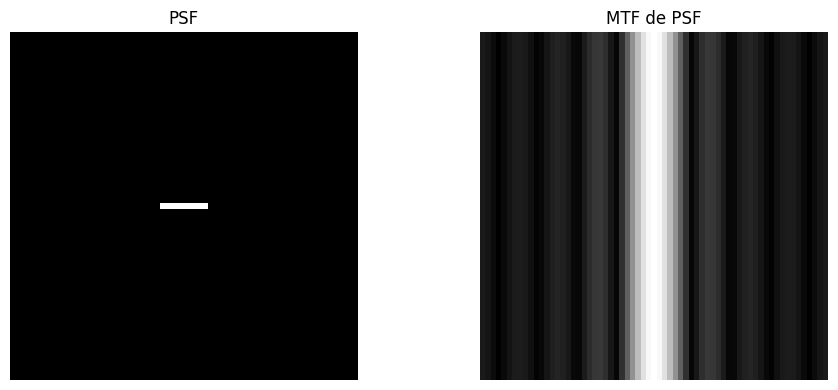

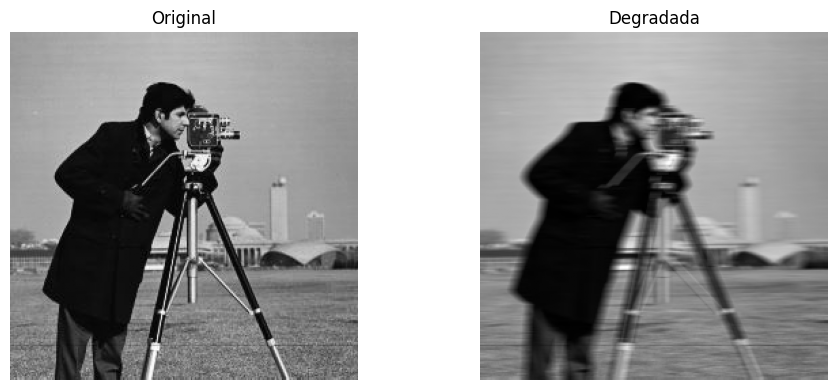

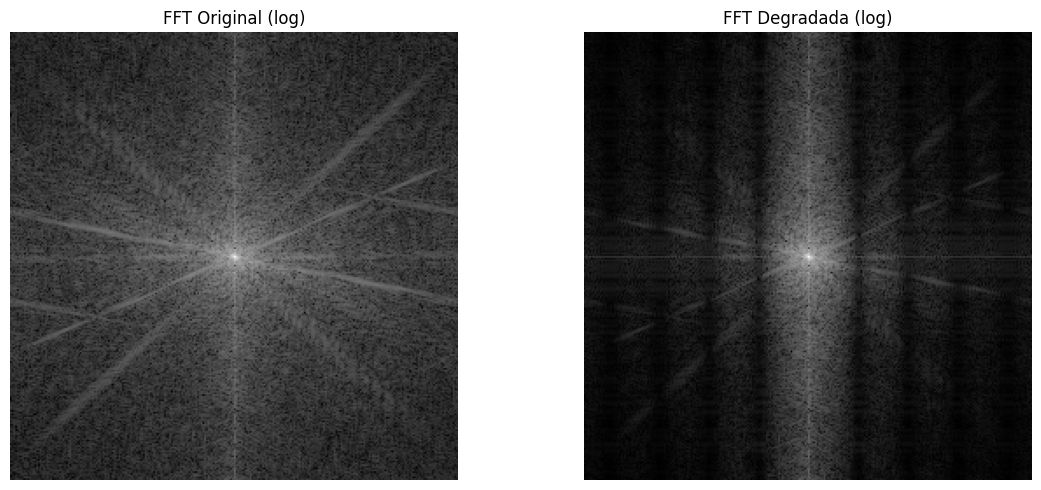

In [ ]:
def calcular_mtf(psf):
    """
En éste caso la mtf nos dice que proporción de cada frecuencia se conserva tras aplicar el desenfoque.
La MTF se interpreta como un mapa donde el valor 1 (blanco)indica que esa frecuencia espacial
se transmite por completo, y los valores inferiores reflejan la atenuación proporcional de cada onda.
La normalización permite compararlas entre PSFs distintas.
    """
    F = np.fft.fft2(psf)          #Calcula la transformada de fourier de 2D de la PSF

    F = np.fft.fftshift(F)        #Se centran en la matriz de frecuencias los componentes de baja frecuencia y en los bordes los de alta, facilitando la visualización.


    mtf = np.abs(F)                #Devuelve la magnitud para cada uno de los números complejos del arreglo F, descartando la fase.

    mtf = mtf/mtf.max()            #Cálcula el valor más alto del arreglo(pico de ganancia en frecuencia),y luego se divide cada elemento por ese máximo.
                                   #Así todos los demás valores quedan en proporción relativa(0 a 1) al máximo.

    return mtf

def mostrar_fft(img, ax, title):
    """
Representa en detalle el espectro FFT de la imagen original o degradada, donde la mayoría
de la energía está concentrada en bajas frecuencias y las frecuencias medias/altas son muy débiles.
Al aplicar log1p(abs) se comprime el rango dinámico, permitiendo apreciar las frecuencias medias/altas.
    """
    G = np.fft.fft2(img)
    G = np.fft.fftshift(G)
    M = np.log1p(np.abs(G))
    ax.imshow(M, cmap='gray')
    ax.set_title(title)
    ax.axis('off')



#Carga de la imagen
ruta_imagen = os.path.join(dir_base_imagenes, 'cameraman.jpg')
img_orig = imread(ruta_imagen, as_gray=True)
img_orig = img_orig.astype(float)


#Visualización de PSF vs MTF
psf = motion_psf()
mtf= calcular_mtf(psf)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(psf, cmap='gray');  plt.title("PSF")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mtf, cmap='gray');  plt.title("MTF de PSF")
plt.axis('off')
plt.tight_layout()
plt.show()

#Convolución en 2 dimensiones
img_degradada = convolve2d(
    img_orig, psf,
    mode='same',   #recorta el resultado para que la salida tenga exactamente el mismo alto y ancho que la imagen original
    boundary='symmetric' #padding, dónde cada valor es el reflejo de la imagen que está justo en el borde
)

#Ploteo
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_orig, cmap='gray');    plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_degradada, cmap='gray');plt.title("Degradada"); plt.axis('off')
plt.tight_layout()
plt.show()



#Comparación de espectros
fig, axs = plt.subplots(1, 2, figsize=(12,5))
mostrar_fft(img_orig,     axs[0], "FFT Original (log)")
mostrar_fft(img_degradada, axs[1], "FFT Degradada (log)")
plt.tight_layout()
plt.show()


**2. Restaurar fotografías de actores.**

Dadas fotografías movidas tomadas durante una gala de premios, se busca identificar cada uno de los actores en las fotos. Para ello restaure cada una de las imágenes utilizando técnicas disponibles, sean de [skimage.restoration](https://scikit-image.org/docs/stable/api/skimage.restoration.html#module-skimage.restoration) y/o de [DeconvolutionLab](https://bigwww.epfl.ch/deconvolution/deconvolutionlab2/). Las técnicas elegidas deben ser explicadas en cuanto a su funcionamiento


Las imágenes a utilizar se encuentran en el directorio [imagenes/actores_mov](./imagenes/actores_mov/)

_Nota: se recomiendan dos maneras para estimar la PSF:_
* Visualizar la imagen y estimar largo y angulo a partir de lineas en el sentido del movimiento
* Visualizando la FFT

###Flujo de trabajo

**1. Estimación inicial de la PSF en Fiji**  
Abro la imagen borrosa en Fiji, trazo con la herramienta Línea la dirección y longitud del desenfoque, y mido el ángulo y la distancia con anlyze usando measure.

**2. Exploración por mosaicos en Python**  
Llamo a mi función mosaic_deconv() para generar un mosaico grueso, variando ±10 px en largo y ±5° en ángulo con pasos de 2. Inspecciono visualmente cada restauración, luego ajusto los rangos y uso pasos de 1 px/1° para refinar la búsqueda de la PSF óptima.

**3. Selección manual de parámetros**  
A partir del mosaico fino, identifico el par (largo, ángulo) que me da el mejor equilibrio entre nitidez de bordes y uniformidad de fondo.

**4. Guardar el resultado definitivo**  
Con los parámetros elegidos y el número óptimo de iteraciones, llamo a guardar_img_deconv() para generar y almacenar la imagen restaurada en la carpeta actores_mov_deconv(dentro de la carpta imagenes).


### Algoritmo Richarson-Lucy
**Ruido Poisson**

Cada píxel de una cámara cuenta fotones que llegan de manera aleatoria: a veces un poco más, a veces un poco menos. Estas fluctuaciones siguen la distribución de Poisson, en dónde la varianza de la señal es igual a su valor medio. En otras palabras:

    La desviación típica (σ) es √μ, donde μ es el número medio de fotones.

    La incertidumbre relativa es σ/μ = √μ / μ = 1 / √μ.

Por ello, cuando llegan muchos fotones, las variaciones absolutas pueden ser relativamente grandes, pero su impacto (en porcentaje) es pequeño, y la imagen sale limpia.
Cuando llegan pocos fotones, incluso pequeñas variaciones absolutas suponen un gran porcentaje de error y el ruido se hace muy visible.
El algoritmo deconvolutivo usado asume precisamente ese modelo de ruido de conteo.


**Algoritmo Richardson–Lucy**

El algoritmo parte de la imagen borrosa como primera estimación de lo que sería la imagen nítida. En cada iteración, vuelve a difuminar esa estimación con la PSF y compara el resultado con la imagen original para ver dónde sobra o falta intensidad. Esa diferencia se “propaga hacia atrás” a lo largo del patrón de desenfoque y se aplica multiplicativamente sobre la estimación previa, de modo que donde faltaba señal se aumenta y donde sobraba se reduce. Gracias a este esquema multiplicativo se garantizan dos propiedades físicas importantes: los valores siempre permanecen no negativos y la suma total de fotones se conserva. El número de iteraciones controla el equilibrio entre restauración de detalle y amplificación de ruido: pocas iteraciones dejan algo de blur, muchas pueden generar artefactos.

In [ ]:
from skimage import io, restoration, transform


def rl_deconvolution(orig_pad, largo, angulo, iterations, psf_size):

    psf = motion_psf(largo, angulo, sz=psf_size)

    #Aplico la deconvolución RL a la imagen con padding (orig_pad),
    #ejecutando iteraciones y permitiendo valores fuera de[0,1] brevemente
    deconv = restoration.richardson_lucy(orig_pad, psf, num_iter=iterations, clip=False)

    #Quito el padding reflectante: extraigo el subarray que corresponde al tamaño original
    corto_padding = deconv[psf_size//2 : -psf_size//2, psf_size//2 : -psf_size//2]

    norm = np.clip(corto_padding, 0, None)#Rechazo valores negativos
    return (norm - norm.min()) / (norm.max() - norm.min())#Escalo linealmente a rango[0,1] para visualizar o guardar



def mosaic_deconv(
    image_path,
    largo0, ang0,
    delta_largo, step_largo,
    delta_ang,   step_ang,
    iterations,
    psf_size
):
    """
    Genera y muestra un mosaico de restauraciones variando el PSF.

    Parámetros:
    - image_path: ruta a la imagen movida.
    - largo0, ang0: estimación inicial de PSF (longitud en px, ángulo en grados).
    - delta_largo: ±píxeles a explorar en largo.
    - step_largo: paso de muestreo en largo.
    - delta_ang: ±grados a explorar en ángulo.
    - step_ang: paso de muestreo en ángulo.
    - iterations: número de iteraciones de RL.
    - psf_size: tamaño del kernel PSF (pixeles).
    """
    #valores de PSF
    largo_vals = list(range(largo0 - delta_largo, largo0 + delta_largo + 1, step_largo))
    angle_vals = list(range(ang0 - delta_ang,   ang0 + delta_ang + 1,   step_ang))

    #cargar imagen y padding
    orig = io.imread(image_path, as_gray=True).astype(np.float64)
    pad_w = psf_size // 2
    orig_pad = np.pad(orig, pad_w, mode='reflect')

    nrows, ncols = len(angle_vals), len(largo_vals)
    figsize = (ncols * 3, nrows * 3)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    #plot restauraciones
    for i, ang in enumerate(angle_vals):
        for j, largo in enumerate(largo_vals):
            restored = rl_deconvolution(orig_pad, largo, ang, iterations, psf_size)
            ax = axes[i, j] if nrows>1 and ncols>1 else (axes[j] if nrows==1 else axes[i])
            ax.imshow(restored, cmap='gray')
            ax.axis('off')

    #etiquetas externas: columnas (largo) arriba
    for j, largo in enumerate(largo_vals):
        x = (j + 0.5) / ncols
        fig.text(x, 0.98, f"L={largo}", ha='center', va='bottom', fontsize=14)
    #filas (ángulo) a la izquierda
    for i, ang in enumerate(angle_vals):
        y = 1 - (i + 0.5) / nrows
        fig.text(0.02, y, f"A={ang}°", ha='left', va='center', rotation=90, fontsize=14)

    plt.subplots_adjust(left=0.1, right=0.98, top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)
    plt.suptitle("", fontsize=18, y=0.99)
    plt.show()



(65, 65)
(65, 65)
(65, 65)
(65, 65)
(65, 65)
(65, 65)
(65, 65)
(65, 65)
(65, 65)


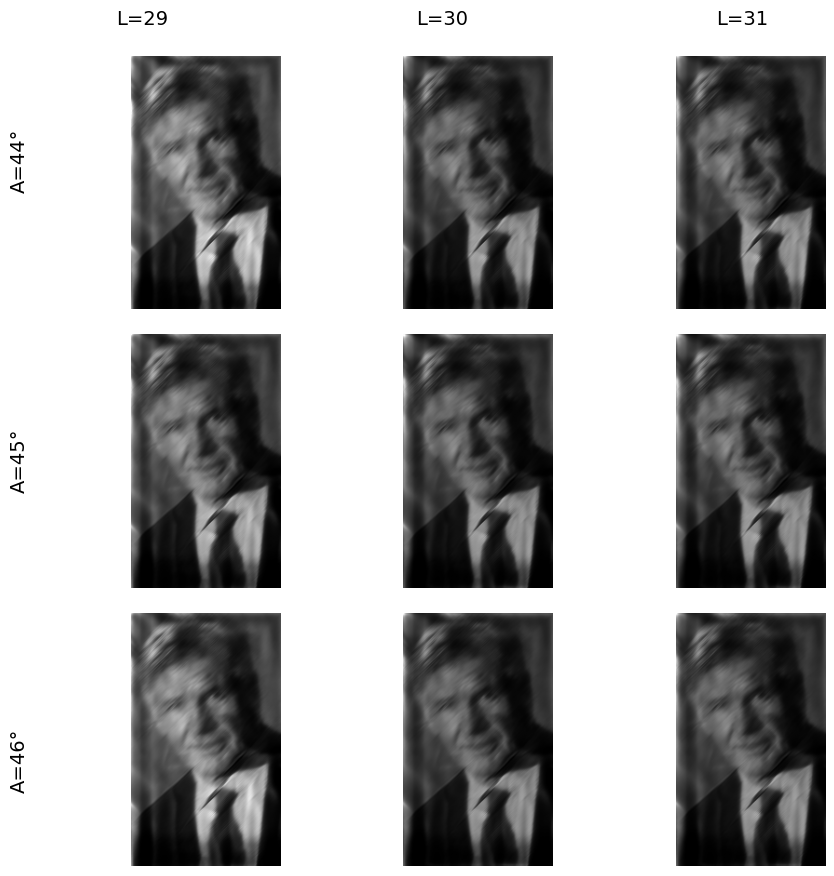

In [ ]:
#Llamada a la función que genera mosaico de imagenes deconvolucionadas
mosaic_deconv(
     "/content/drive/MyDrive/timag/entregable_2/imagenes/actores_mov/act7_mov.png",
     largo0=30, ang0=45,
     delta_largo=1, step_largo=1,
     delta_ang=1,   step_ang=1,
     iterations=35,
     psf_size=65
 )

######Los resultados finales, quedaron guardados en el directorio imagenes, en la carpeta actores_mov_deconv.

In [ ]:
def guardar_img_deconv(
    image_path,
    largo,
    angulo,
    iterations,
    psf_size
):
    """
    Guarda única imagen restaurada en:
      {dir_base_imagenes}/actores_mov_deconv

    Parámetros:
    - image_path: ruta a la imagen con blur.
    - largo, angulo: parámetros de PSF (píxeles y grados).
    - iterations: número de iteraciones usando Richardson-Lucy.
    - psf_size: tamaño del kernel PSF (píxeles).
    """
    #Carpeta específica para imagenes restauradas
    output_dir = os.path.join(dir_base_imagenes, "actores_mov_deconv")
    os.makedirs(output_dir, exist_ok=True)

    base = os.path.splitext(os.path.basename(image_path))[0]

    #Padding y restauración
    img = io.imread(image_path, as_gray=True).astype(np.float64)
    pad = psf_size // 2
    img_pad = np.pad(img, pad, mode='reflect')
    restored = rl_deconvolution(img_pad, largo, angulo, iterations, psf_size)

    #Convertir a uint8 y guardar imagen restaurada
    restored_uint8 = (restored * 255).astype(np.uint8)
    restored_out = os.path.join(
        output_dir,
        f"{base}_deconv-RL_L{largo}_A{angulo}_it{iterations}.png"
    )
    io.imsave(restored_out, restored_uint8)

    print(f"Guardada restaurada en: {restored_out}")
    return restored_out

In [ ]:
#guardar_img_deconv(
#    "/content/drive/MyDrive/timag/entregable_2/imagenes/actores_mov/act7_mov.png",
#    largo=30,
#    angulo=45,
#    iterations=35,
#    psf_size=65
#)

## 3. Transformaciones geométricas

#### 1. Implementar una función que realice transformaciones proyectivas

In [ ]:
def bilineal(I, punto, color_de_fondo):
    """
    Dado un punto de coordenadas no necesariamente enteras y una imagen I,
    retorna la interpolación bilineal entre los cuatro pixeles de I más cercanos
    al punto de entrada.

    Args:
    - I (array 2D): Imagen de referencia para interpolar.
    - punto (tuple/list): coordenadas en imagen en formato: punto = (fila,columna) ó punto = [fila,columna]
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.

    Returns:
    valor_interpolado : valor interpolado en escala de grises para el punto.
    """
    #Dimensiones de la imagen
    F, C = I.shape[:2]  # F = filas, C = columnas


    """El punto continuo (fila_cont, col_cont) cae dentro del cuadrado definido
    por las esquinas (f0,c0), (f0,c1), (f1,c0) y (f1,c1)"""
    #Coordenadas continuas del punto
    fila_cont, col_cont = punto

    #Vecinos de floor y ceil
    f0 = math.floor(fila_cont)
    c0 = math.floor(col_cont)
    f1 = f0 + 1
    c1 = c0 + 1

    #Pesos (distancias fraccionales)
    """delta_c y delta_f son las distancias fraccionales a la columna derecha (c1)
    y a la fila inferior (f1) respectivamente"""
    delta_c = col_cont - c0
    delta_f = fila_cont - f0


    #Función para extraer valor o asignar valor de fondo(si cae afuera de la imagen)
    def valor_o_fondo(f, c):
        if f < 0 or f >= F or c < 0 or c >= C:
            return color_de_fondo
        return I[f, c]

    #Los vertices del cuadrado
    #I00 = (f0,c0), I01 = (f0,c1), I10 = (f1,c0), I11 = (f1,c1)
    I00 = valor_o_fondo(f0, c0)
    I01 = valor_o_fondo(f0, c1)
    I10 = valor_o_fondo(f1, c0)
    I11 = valor_o_fondo(f1, c1)


    """
Interpolación horizontal
Para la fila de arriba, “mezclamos” el gris del píxel izquierdo y el del derecho según qué tan
cerca esté el punto de cada uno; el resultado es I_top.Repetimos lo mismo en la fila de abajo para obtener I_bottom.
Interpolación vertical
Finalmente, combinamos I_top e I_bottom según qué tan cerca esté el punto de la fila superior o de la inferior;
el resultado es el gris interpolado en la posición continua.
En resumen: primero se “difuminan” los valores a lo largo de la fila (izquierda–derecha),
luego se vuelven a mezclar esos dos resultados a lo largo de la columna (arriba–abajo) para obtener un valor suave y coherente."""

    # 7) Interpolación horizontal en las dos filas del cuadrado de píxeles

    # I_top: valor interpolado entre el píxel superior-izquierdo (I00) y
    #        el píxel superior-derecho (I01).
    # - (1 - delta_c) es el peso que indica cuán cerca está el punto de la columna c0 (izquierda).
    # -   delta_c    es el peso que indica cuán cerca está de la columna c1 (derecha).
    # Resultado: un gris intermedio en la fila f0, según la cercanía horizontal.
    I_top    = (1 - delta_c) * I00 + delta_c * I01

    # I_bottom: valor interpolado entre el píxel inferior-izquierdo (I10) y
    #           el píxel inferior-derecho (I11).
    # Mismos pesos horizontales:
    # - (1 - delta_c) acerca al valor de la columna izquierda en la fila f1.
    # -   delta_c    acerca al valor de la columna derecha en la fila f1.
    # Resultado: un gris intermedio en la fila f1.
    I_bottom = (1 - delta_c) * I10 + delta_c * I11

    # 8) Interpolación vertical entre I_top e I_bottom

    # - (1 - delta_f) es el peso que indica cuán cerca está el punto de la fila f0 (superior).
    # -   delta_f    es el peso que indica cuán cerca está de la fila f1 (inferior).
    # Al mezclar I_top e I_bottom con estos pesos,
    # obtenemos el valor final que refleja la posición vertical del punto dentro del cuadrado.
    valor_interpolado = (1 - delta_f) * I_top + delta_f * I_bottom


    return valor_interpolado

def vecino(img, punto, color_de_fondo):
    """
    Dado un punto de coordenadas no necesariamente enteras y una imagen I,
    retorna el nivel de gris correspondiente al pixel más cercano I.

    Args:
    - I (array 2D): Imagen de referencia para interpolar.
    - punto (tuple/list): coordenadas en imagen en formato: punto = (fila,columna) ó punto = [fila,columna]
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.

    Returns:
    valor_interpolado : valor interpolado en escala de grises para el punto.
    """

    #Me quedo con las entradas de ancho y largo, dejo afuera el color
    F, C = I.shape[:2]  #F = filas, C = columnas

    #Coordenadas continuas
    fila_cont, col_cont = punto

    #Redondeo al píxel más cercano
    #round() elige el entero más cercano, en empates (.5) redondea al par de valores más cercano
    fila_int = int(round(fila_cont))
    col_int = int(round(col_cont))

    #Si el valor de fila o columna del punto ésta fuera del rango, se le asigna color de fondo
    if fila_int < 0 or fila_int >= F or col_int < 0 or col_int >= C:
        valor_interpolado = color_de_fondo
    else:
        valor_interpolado = I[fila_int, col_int]

    return valor_interpolado

def transformar(I, T, tipo_interpolacion='vecino', color_de_fondo=0):
    """
    Aplicar una transformacion geometrica T a imagen I, especificando el tipo de interpolacion.

    Args:
    - I (array 2D): imagen a transformar.
    - T (array 2D): matriz de transformacion de tamaño 3x3.
    - tipo_interpolacion (str): interpolación a utilizar: 'vecino' más cercano (default) o 'bilineal'.
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.

    Returns:
    I_transformada (array 2D): imagen transformada

    """
    # 1) Extraer dimensiones de la imagen original
    F, C = I.shape[:2]  # F = filas, C = columnas

    # 2) Inicializar imagen destino con color de fondo
    I_transformada = np.full((F, C), color_de_fondo, dtype=I.dtype)

    # 3) Calcular la matriz inversa para mapeo inverso
    T_inv = np.linalg.inv(T)

    # 4) Recorrer cada píxel (i, j) de la imagen destino
    for i in range(F):
        for j in range(C):
            # 4.1) Crear punto homogéneo de destino
            p_dst = np.array([j, i, 1.0])

            # 4.2) Mapear inversamente al espacio original
            p_src_h = T_inv @ p_dst

            # 4.3) Convertir coordenadas homogéneas a continuas
            x_s = p_src_h[0] / p_src_h[2]  # columna continua
            y_s = p_src_h[1] / p_src_h[2]  # fila continua

            # 5) Interpolar según el método elegido
            if tipo_interpolacion == 'vecino':
                valor = vecino(I, (y_s, x_s), color_de_fondo)
            else:  # 'bilineal'
                valor = bilineal(I, (y_s, x_s), color_de_fondo)

            # 6) Asignar el valor interpolado al píxel destino
            I_transformada[i, j] = valor

    return I_transformada

#### 2. Usando la función transformar, mostrar ejemplos de transformaciones isométricas, afines y proyectivas  con diferentes interpolaciones

Parecido a lo que se muestra en [estos ejemplos de scikit-image](https://scikit-image.org/docs/stable/auto_examples/transform/plot_transform_types.html).


#### Mostrar una rotación con origen en vértice superior izquierdo de la imagen (origen de coordenadas)

antes de escalar: 0.0 1.0
después de escalar: 0.0 255.0


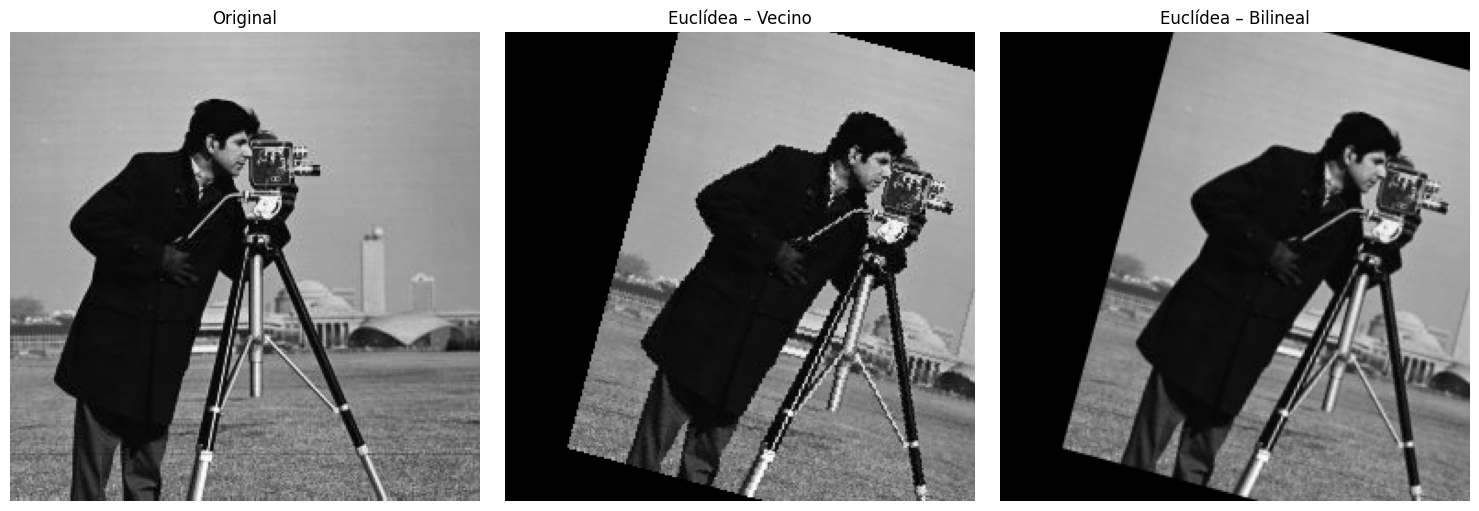

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import transform as sktf

#Carga de imagen y dejarla en rango[0,255]

ruta_imagen = os.path.join(dir_base_imagenes, 'cameraman.jpg')
img_orig = imread(ruta_imagen, as_gray=True).astype(float)

print("antes de escalar:", img_orig.min(), img_orig.max())
if img_orig.max() <= 1.0:
    img_orig *= 255
print("después de escalar:", img_orig.min(), img_orig.max())

#Parámetros Euclídeos
theta = np.pi / 12         # rotación = 15°
tx, ty = 100, -20          #traslación en x, y


# Construcción de la matriz homogénea Euclídea
#Gracias a las coordenadas homogéneas, esta matriz
#realiza en un solo paso rotación (submatriz 2×2) y traslación (columna t).

tform = sktf.EuclideanTransform(rotation=theta,
                                 translation=(tx, ty))
T_euc = tform.params
# T_euc == [[ cosθ, -sinθ, tx ],
#           [ sinθ,  cosθ, ty ],
#           [   0 ,    0 ,  1 ]]

# Aplico función transformar
# Primero invertimos la matriz para hacer mapeo inverso
# Luego, para cada píxel destino (i,j) preguntamos “¿de dónde vengo?”
# Extraemos coords continuas en la original y aplicamos interpolación
I = img_orig
I_vecino   = transformar(I, T_euc,
                         tipo_interpolacion='vecino',
                         color_de_fondo=0)
I_bilineal = transformar(I, T_euc,
                         tipo_interpolacion='bilineal',
                         color_de_fondo=0)

#Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(I, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(I_vecino, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Euclídea – Vecino")
axes[1].axis('off')

axes[2].imshow(I_bilineal, cmap='gray', vmin=0, vmax=255)
axes[2].set_title("Euclídea – Bilineal")
axes[2].axis('off')

plt.tight_layout()
plt.show()


#### Mostrar una rotación con origen en el centro de la imagen
La transformación de rotación en el centro de la imagen puede calcularse como la composición de una traslación, una rotación y una traslación.  

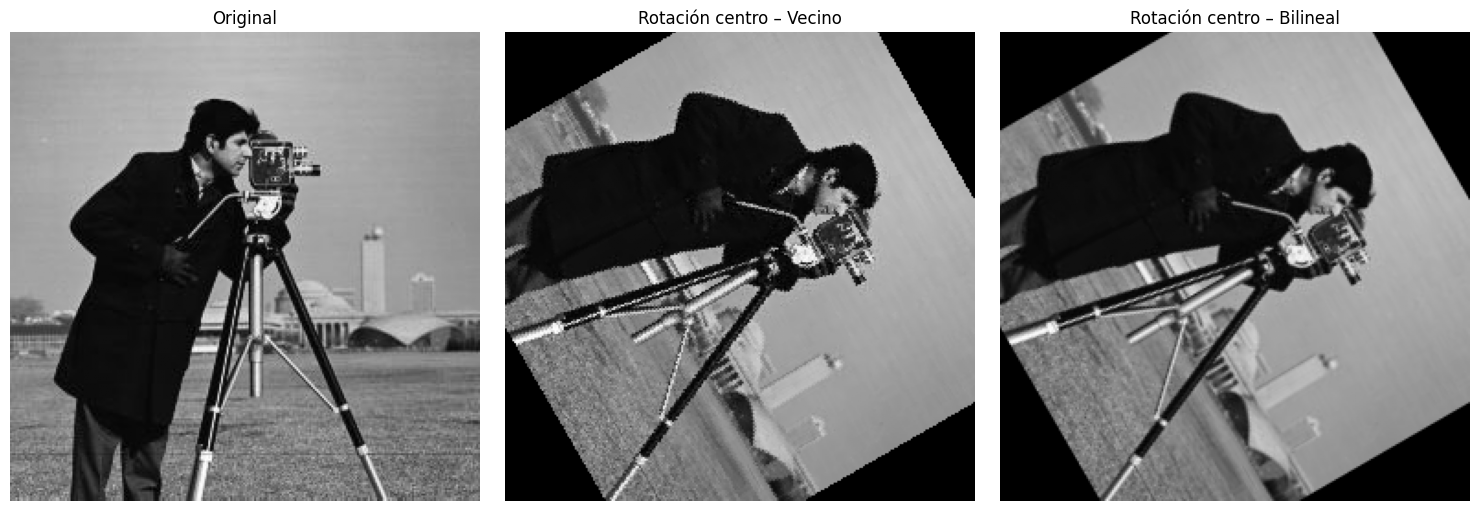

In [ ]:
# Muestre las matrices correspondientes a las tres transformaciones



# Calcule la matriz de rotación en el centro como la composición de las tres transformaciones anteriores



# Aplique la transformación y muestre el resultado

#La imagen yá está definida y en rango [0,255]
F, C = I.shape           #F = filas, C = columnas
cx, cy = C / 2.0, F / 2.0  #(c_x, c_y): centro de la imagen


#Matriz T1: trasladar el centro al origen
#Esto garantiza que la rotación gire alrededor del centro deseado
T1 = np.array([
    [1, 0, -cx],   # x -> x - c_x
    [0, 1, -cy],   # y -> y - c_y
    [0, 0,    1]
], dtype=np.float64)


#Matriz R: rotación pura en el origen usando cos y sin
theta = np.pi / 3  # rotación de 30°
cos_t, sin_t = np.cos(theta), np.sin(theta)
R = np.array([
    [ cos_t, -sin_t, 0],
    [ sin_t,  cos_t, 0],
    [     0,      0, 1]
], dtype=np.float64)
#    La submatriz 2×2 es la rotación lineal, la columna [0,0,1] mantiene w=1

# 4) Matriz T2: trasladar de vuelta el origen al centro original
#    Devuelve el punto de pivote a su posición en la imagen
T2 = np.array([
    [1, 0, cx],   # x -> x + c_x
    [0, 1, cy],   # y -> y + c_y
    [0, 0,   1]
], dtype=np.float64)

# 5) Composición: rotación efectiva alrededor del centro
#    Primer T1 (centro->origen), luego R (rotar), luego T2 (origen->centro)
T_center = T2 @ R @ T1

# 6) Aplicar la transformación:
#    - 'vecino': interpolación por vecino más cercano (bordes escalonados)
#    - 'bilineal': interpolación bilineal (suavizado)
#    Ambas usan color_de_fondo=0 cuando la fuente cae fuera del rango
I_rot_vecino   = transformar(I, T_center, tipo_interpolacion='vecino',    color_de_fondo=0)
I_rot_bilineal = transformar(I, T_center, tipo_interpolacion='bilineal', color_de_fondo=0)

# 7) Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(I, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(I_rot_vecino, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Rotación centro – Vecino")
axes[1].axis('off')

axes[2].imshow(I_rot_bilineal, cmap='gray', vmin=0, vmax=255)
axes[2].set_title("Rotación centro – Bilineal")
axes[2].axis('off')

plt.tight_layout()
plt.show()


#### Mostrar una transformación afin

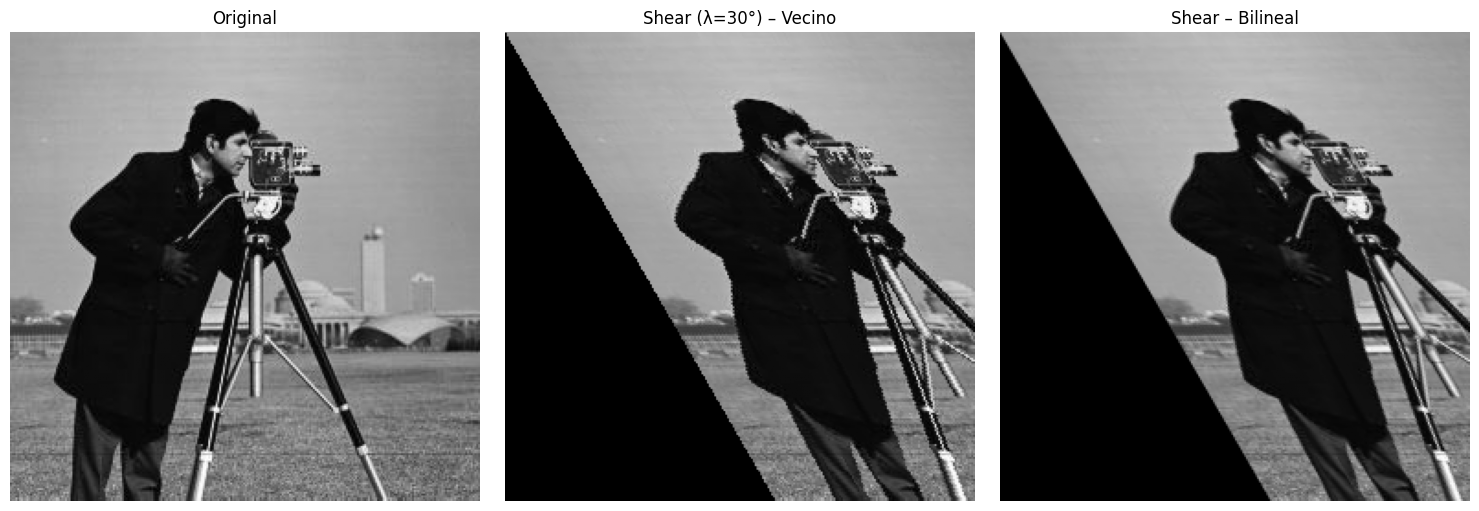

In [ ]:
#Defino parámetro de shear
lambda_shear = np.pi / 6   # 30° de sesgo en X

#La matriz afín de shear pura en x:
#  [1, tan(λ), 0]
#  [0,    1  , 0]
#  [0,    0  , 1]
T_shear = np.array([
    [1, np.tan(lambda_shear), 0],
    [0, 1,                    0],
    [0, 0,                    1]
], dtype=np.float64)

# Aplico con las funciones definidas (vecino y bilineal)

I_shear_vecino   = transformar(I, T_shear,
                               tipo_interpolacion='vecino',
                               color_de_fondo=0)
I_shear_bilineal = transformar(I, T_shear,
                               tipo_interpolacion='bilineal',
                               color_de_fondo=0)

#Visualización
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(I, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(I_shear_vecino, cmap='gray', vmin=0, vmax=255)
axes[1].set_title(f"Shear (λ={lambda_shear*180/np.pi:.0f}°) – Vecino")
axes[1].axis('off')

axes[2].imshow(I_shear_bilineal, cmap='gray', vmin=0, vmax=255)
axes[2].set_title("Shear – Bilineal")
axes[2].axis('off')

plt.tight_layout()
plt.show()

#### Mostrar una transformación proyectiva

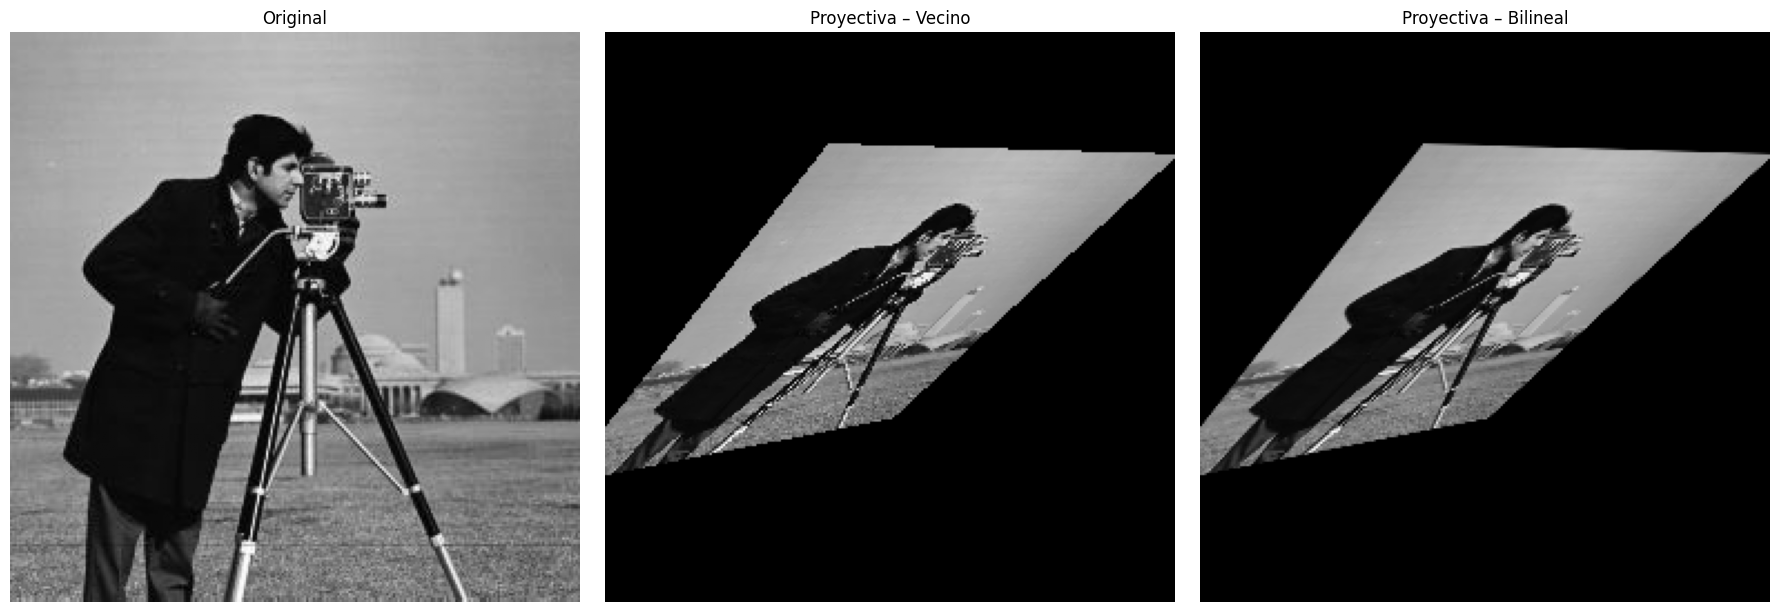

In [ ]:
# — 2) Definir la matriz proyectiva de ejemplo —
#    Ejemplo sencillo: enviamos esquinas a un trapecio
#    [h11, h12, h13]   [1, -0.5, 100]
#    [h21, h22, h23] = [0.1, 0.9,  50]
#    [h31, h32, h33]   [0.0015, 0.0015, 1]

#Importante:
#La Submatriz 2×2 (h11,h12,h21,h22) => gira, escala o inclina la imagen sin perspectiva, como en la transformación afín
#Columna (h13,h23) de traslación mueve toda la imagen en X e Y => desplazamiento
#(h31,h32) ≠ (0,0) introducen la componente proyectiva. Mientras que h33 = 1 fija el hiperplano w=1 en el resultado
#

H = np.array([
    [1.0,    -0.5,   100.0],
    [0.1,     0.9,    50.0],
    [0.0015,  0.0015,  1.0]
], dtype=np.float64)


#Aplicar la homografía con tus funciones existentes —
I_proj_vecino   = transformar(I, H, tipo_interpolacion='vecino',    color_de_fondo=0)
I_proj_bilineal = transformar(I, H, tipo_interpolacion='bilineal', color_de_fondo=0)

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(I, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(I_proj_vecino, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Proyectiva – Vecino")
axes[1].axis('off')

axes[2].imshow(I_proj_bilineal, cmap='gray', vmin=0, vmax=255)
axes[2].set_title("Proyectiva – Bilineal")
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 4. Segmentación de líneas con la transformada de Hough

#### 1. Dibujo de líneas

Para visualizar las lineas detectadas se implementará una función que dada la imagen y sus lineas (en parámetros $\theta$ y $r$), sean graficadas sobre la imagen. Ver [lineas de Hough](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html).

Notar que se puede implementar esta función sin necesidad de encontrar las lineas de una imagen.

In [ ]:
def plot_lineas_hough(thetas, rhos, img_shape=None, ax=None):
    '''
    Graficar líneas dadas por su representación en transformada de Hough.

    Parameters
    ----------
    thetas (list o 1D array): ángulo en radianes para cada línea.
    rhos (list o 1D array): distancia en píxeles para cada línea.
    img_shape (tuple): tamaño de la imagen la cual fueron calculadas las lineas.
    ax (Axes de matplotlib) : eje de figura a graficar. Ignorar para graficar en
                            la última imagen generada por 'plt.figure(...)'

    '''

    assert(len(thetas)==len(rhos)), 'Deben haber misma cantidad de ángulos que de distancias!'

    if ax is None:
        # Obtener axis predeterminado
        ax = plt.gca() #obtiene el eje actual de Matplotlib

    if img_shape is None:
        # Valores por defecto para graficar limites (x,y)
        x_limit = 1000
        y_limit = 1000
    else:
        (y_limit, x_limit) = img_shape#img_shape = (alto, ancho) → invertimos al asignar


    for (theta,rho) in zip(thetas, rhos):
        #Calcular coseno y seno de theta para usar en la ecuación polar de la linea: x·cosθ + y·sinθ = ρ
        cos_t = np.cos(theta)
        sin_t = np.sin(theta)

        #Caso general (sinθ ≠ 0): resolvemos intersecciones con bordes verticales
        #con X=0 y X=Xmax usando la ecuación polar
        if abs(sin_t) > 1e-6:
            #Punto de intersección con el borde izquierdo (x = 0):
            x0 = 0
            y0 = rho / sin_t  #despejamos y: y = ρ / sinθ

            #Punto de intersección con el borde derecho (x = x_limit):
            x1 = x_limit
            y1 = (rho - x1 * cos_t) / sin_t  # despejamos y en la ecuación polar
        else:
            #Caso especial: línea vertical (sinθ ≈ 0)
            # Para evitar división por cero:Ecuación reduce a x = ρ / cosθ
            x0 = x1 = rho / cos_t
            # Extendemos la línea cubriendo toda la altura de la imagen
            y0, y1 = 0, y_limit

        #Trazar la línea en el Axes: coord X,Y, color de linea y grosor
        ax.plot(
            (x0, x1),
            (y0, y1),
            '-r',
            linewidth=2
        )

    #Ajustar límites y aspecto de los ejes:
    ax.set_xlim(0, x_limit)         #eje X desde 0 hasta el ancho
    ax.set_ylim(y_limit, 0)         #eje Y invertido para origen arriba-izquierda
    ax.set_aspect('equal')          #mantener proporciones iguales en X y Y


In [ ]:
def plot_hough_accumulator(hspace, theta, rho, ax):
    '''
    Dibuja el acumulador de Hough con ejes en θ (grados) y ρ (píxeles),
    incluyendo la conversión a grados, el cálculo de extent y el uso de log1p.
    '''
    # EJE X DEL ACUMULADOR
    # Convertimos theta a grados para etiquetar el eje X
    theta_deg = np.rad2deg(theta)

    # ¿Cómo defino los bordes de los ejes θ y ρ?
    """
    Para que el acumulador muestre exactamente los rangos de ángulo y distancia que cada
    “banda” cubre, calculamos primero el ancho real de cada bin de θ y de ρ.
    A continuación, tomamos justo la mitad de ese ancho y la restamos al primer valor
    y la sumamos al último, de modo que los bordes del gráfico coincidan con los límites reales de cada bin
    """
    angle_step = 0.5 * np.diff(theta_deg).mean()
    rho_step   = 0.5 * np.diff(rho).mean()

    # extent define [xmin, xmax, ymin, ymax] para que imshow mapee correctamente índices→valores
    extent = [
        theta_deg[0]  - angle_step,   # X mínimo en grados
        theta_deg[-1] + angle_step,   # X máximo en grados
        rho[-1]       + rho_step,     # Y mínimo (rho más grande en la parte inferior)
        rho[0]        - rho_step      # Y máximo (rho más pequeño en la parte superior)
    ]

    # Aplicamos log1p para resaltar picos bajos
    """
    Siendo v = valor en el acumulador; al aplicar log(1 + v):
    El aumento de log es suave cuando v es grande y más pronunciado cuando v es pequeño.
    Como consecuencia: se achica la brecha entre valores muy altos y muy bajos,
    permitiendo ver tanto el pico dominante como los picos menores que antes quedaban ocultos
    """
    ax.imshow(
        np.log1p(hspace),
        cmap='gray',
        aspect='auto',
        extent=extent
    )
    ax.set_title('Acumulador')
    ax.set_xlabel('θ (grados)')
    ax.set_xticks(np.linspace(-90, 90, 7))  # marcas cada 30°
    ax.set_ylabel('ρ (píxeles)')

#### Mostrar el funcionamiento de plot_lineas_hough para distintos valores theta-rho
  

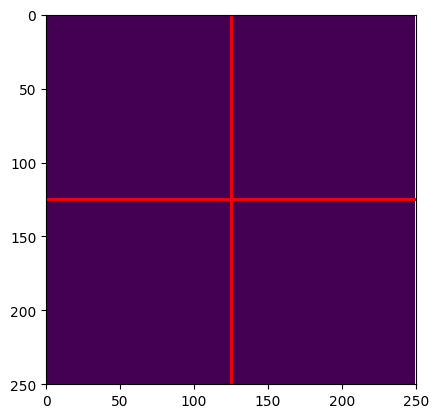

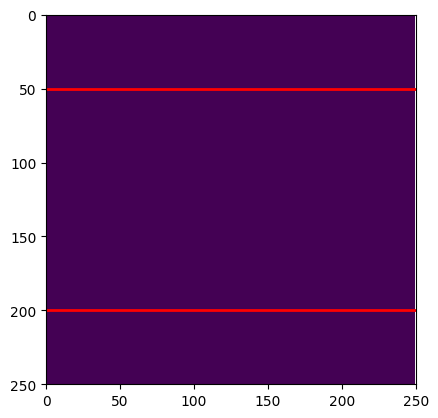

In [ ]:
# Imagen vacía a plottear
zeros = np.zeros((250,250))

# líneas vertical y horizontal que pasan por la mitad de la imagen
angles_case1 = np.array([0, np.pi / 2])  # Vertical and horizontal angles
rhos_case1 = np.array([125, 125])      # Both pass through the center

# líneas horizontales con rho 50
angles_case2 = np.array([np.pi / 2, np.pi / 2])  # Horizontal lines
rhos_case2 = np.array([50, 200])


# Inicializar figura
# Plot lineas
plt.figure()
plt.imshow(zeros)
plot_lineas_hough(angles_case1, rhos_case1, img_shape=zeros.shape, ax=None)
plt.show()

# Inicializar figura
# Plot lineas2
plt.figure()
plt.imshow(zeros)
plot_lineas_hough(angles_case2, rhos_case2, img_shape=zeros.shape, ax=None)
plt.show()


#### 2. Funcionamiento de lineas_hough

Para este ejercicio se utilizará la [implementación de skimage](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line) para poder acceder al acumulador del espacio $(\theta, r)$.

Explicar qué parámetros toma la función [hough_line](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line) y qué retorna. Comentar brevemente cómo se usan dichas salidas usando [hough_line_peaks](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line_peaks) para obtener las lineas principales.

Para las siguientes imágenes artificiales sencillas:

a) detectar líneas  
b) mostrar el acumulador y plotear las rectas    
c) relacionar el contenido del acumulador con las rectas correspondientes    

#### Contexto Teorico integrador
Tradicionalmente describimos una recta como:

    y=mx+c ; siendo m=(y2-y1)/(x2-x1) la pendiente
Esta forma presenta un problema cuando la linea se vuelve vertical, o sea **(X2-x1 -> 0)**, generando que esa pendiente crezca hasta el **infinito** y deje de tener sentido practico.
En nuestro lienzo digital, el pixel(0,0)/**origen** está en la **esquina superior izquierda**, con el eje X a la derecha y el eje Y hacia abajo. Para evitar pendientes infinitas, representamos cada recta mediante un vector normal que parte de ese origen, forma un ángulo θ con el eje X y choca, tras recorrer una distancia ρ, contra la línea. Así llegamos a la ecuación de la recta en coordenadas de Hough:

    xcosθ+ysinθ=ρ

Y un **solo punto (x,y)** no determina una única recta, sino **infinitas**: todas las líneas que lo atraviesan.
En la transformada de Hough, cada uno de esos puntos “vota” por cada posible línea, traduciendose en el **acumulador como una sinusoide**:

    ρ(θ)=xcosθ+ysinθ

Que recoge la distancia para cada ángulo. Cuando varias sinusoides de distintos puntos coinciden, surge un pico de alta votación—esa es la señal de una recta compartida.

Es importante alcarar que una misma recta admite dos normales opuestas (separadas 180°), lo que en el acumulador aparece como dos picos simétricos (θ,ρ) y (θ±180°,-ρ). or eso, dos picos opuestos no significan dos líneas paralelas, sino dos descripciones de la misma linea.

Finalmente, tras generar el acumulador con hough_line() y extraer sus picos con hough_line_peaks(), obtenemos(ρ* , θ*) que describen la linea que pasa por lo puntos.

Para dibujar la recta resultante en la imagen calculamos:

    (Xo,Yo) = (p*cosθ*,p*sinθ*)

    con pendiente

    -cosθ*/sinθ*



#####Parametros: **hough_line** , **hough_line_peaks** y el parametro **extent[ ]** de imshow()

#####**hough_line()**

hspace, angles, dists = hough_line(image, theta=None)

Calcula la transformada de Hough para detectar líneas en una imagen binaria o de bordes.

**Parámetros**  
1.image (ndarray 2D): imagen de entrada (normalmente binaria o resultado de un detector de bordes).  
2.theta (array_like, opcional): valores de ángulo (en radianes) a muestrear. Si no se provee, utiliza un rango lineal de \([-π/2, +π/2)\) en 180 grados.

**Retornos**  
1.hspace (ndarray 2D): acumulador de votos con forma (len(dists), len(angles)).  Cada celda (i,j) acumula cuántos píxeles de borde respaldan la línea definida.

2.angles (ndarray 1D): valores de θ (columnas de hspace).

3.dists (ndarray 1D): valores de ρ (filas de hspace).


######**hough_line_peaks()**

**Parámetros**

1.Los retornos de **hough_line**: hspace, angles, dists

2.threshold(float,opcional) : umbral mínimo de votos para considerar un pico (por defecto 0).

3.num_peaks(int,opcional) : cuántos máximos extraer (por defecto todos por encima de threshold).

4.min_distance(int,opcional) : separación mínima (en celdas) entre picos detectados.

**Retornos**

1.accum_peaks(ndarray 1D): valores de voto en cada pico detectado.

2.angle_peaks(ndarray 1D): valores de θ correspondientes a esos picos.  

3.dist_peaks(ndarray 1D): valores de ρ correspondientes a esos picos.



#####**extent[ ]**

Toma el borde izquierdo de este dibujo y considéralo como –90°; el borde derecho, como +90°. Del mismo modo, el borde superior conviértelo en el valor mínimo de ρ, y el inferior en el máximo. Luego estira todo el dibujo para que esas posiciones coincidan con ese rango de parámetros.
De este modo, en vez de ver una malla de puntos, ves un mapa donde el eje horizontal está en grados y el vertical en píxeles de distancia.

**En resumen:**

El primer valor de extent marca el límite mínimo de X ( enéste caso –90°) y el segundo el máximo de X (+90°).

El tercer valor es el límite inferior de Y ( ρ mínimo) y el cuarto el superior (ρ máximo).

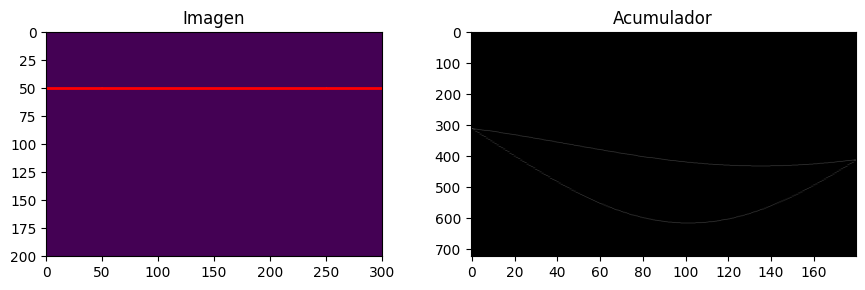

In [ ]:
#Ejemplo 1
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[50,250]=255

#Cálculo de transformada de Hough
#hspace: acumulador de votos (ρ vs. θ)
#theta: array de valores de ángulo muestreados (en radianes)
#rho: array de valores de distancia (en píxeles)
hspace, theta, rho = hough_line(I)

#Mostrar imagen y acumulador de Hough
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(9,3))
ax[0].imshow(I) ; ax[0].set_title('Imagen')
ax[1].imshow(hspace, cmap='gray', aspect='auto'); ax[1].set_title('Acumulador')


#accum_peaks: número de votos en el pico
#angle_peaks: valor de θ del pico
#dist_peaks: valor de ρ del pico
# Filtrar acumulador, obtener lineas y graficar
accum, angles, dists = hough_line_peaks(hspace, theta, rho, num_peaks=1)

plot_lineas_hough(angles, dists, img_shape=I.shape, ax=ax[0])
ax[0].set_ylim((200,0))
ax[0].set_xlim((0,300))

plt.tight_layout()


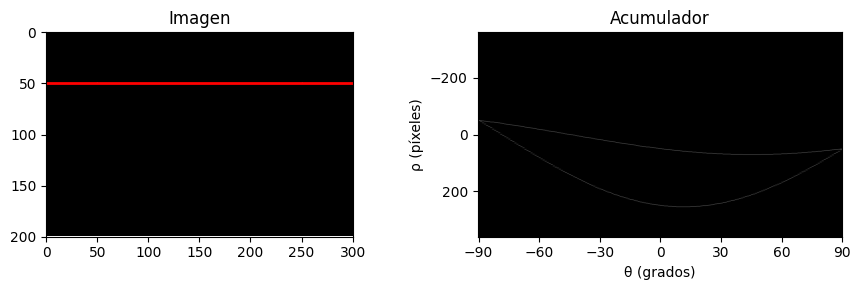

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import hough_line, hough_line_peaks

# Ejemplo 1
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]   = 255
I[50,250]  = 255

#hspace: acumulador de votos
#theta: array de ángulos muestreados (en radianes)
#rho: array de distancias muestreadas (en píxeles)
hspace, theta, rho = hough_line(I)

#EJE X DEL ACUMULADOR

#Convertimos theta a grados para etiquetar el eje X
theta_deg = np.rad2deg(theta)

#¿Como defino los bordes de los ejes θ y ρ?
"""Para que el acumulador muestre exactamente los rangos de ángulo y distancia que cada
“banda” cubre, calculamos primero el ancho real de cada bin de θ y de ρ.
A continuación, tomamos justo la mitad de ese ancho y la restamos al primer valor
y la sumamos al último, de modo que los bordes del gráfico coincidan con los límites reales de cada bin"""

angle_step = 0.5 * np.diff(theta_deg).mean()
rho_step   = 0.5 * np.diff(rho).mean()

#extent define [xmin, xmax, ymin, ymax] para que imshow mapee correctamente índices→valores
extent = [
    theta_deg[0]  - angle_step,   #X mínimo en grados
    theta_deg[-1] + angle_step,   #X máximo en grados
    rho[-1]       + rho_step,     #Y mínimo (rho más grande en la parte inferior)
    rho[0]        - rho_step      #Y máximo (rho más pequeño en la parte superior)
]

# Mostrar imagen y acumulador de Hough
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

# Ploteo izquierdo: la imagen con los puntos(que pueden ser de borde)
ax[0].imshow(I, cmap='gray')
ax[0].set_title('Imagen')



"""Siendo v = valor en el acumulador; al aplicar log(1 + valor_acumulador):
El aumento de log es suave cuando v es grande y más pronunciado cuando v es pequeño.
Como consecuencia: se achica la brecha entre valores muy altos y muy bajos,
permitiendo ver tanto el pico dominante como los picos menores que antes quedaban ocultos
⁡"""

#Ploteo derecho: acumulador con ejes pixeles vs grados
ax[1].imshow(
    np.log1p(hspace),
    cmap='gray',
    aspect='auto',
    extent=extent
)
ax[1].set_title('Acumulador')
ax[1].set_xlabel('θ (grados)')
ax[1].set_xticks(np.linspace(-90, 90, 7))  #marcas cada 30°
ax[1].set_ylabel('ρ (píxeles)')


#extracción de picos y líneas principales
#accum: número de votos en cada pico
#angles: ángulo θ* del pico (en radianes)
#dists: distancia ρ* del pico (en píxeles)
accum, angles, dists = hough_line_peaks(
    hspace, theta, rho,
    num_peaks=1          # extraigo solo la línea más votada
)


#Superpongo la línea detectada sobre la imagen origina
from matplotlib import cm

plot_lineas_hough(angles, dists, img_shape=I.shape, ax=ax[0])
ax[0].set_xlim((0, I.shape[1]))
ax[0].set_ylim((I.shape[0], 0))  # invertir Y para origen arriba-izquierda

plt.tight_layout()
plt.show()


#####Interpretación ejemplo 1:

Cada punto blanco (50,50) y (250,50) no define una sola recta, sino infinitas: todas las que lo atraviesan en distintos ángulos. La transformada de Hough las traduce de rectas a curvas en el espacio (θ,ρ) mediante la ecuación

x·cos θ + y·sin θ = ρ

De modo que cada punto “vota” trazando una sinusoide ρ(θ). Donde varias sinusoides coinciden aparece un pico en el acumulador, señal de la recta que comparten.

En nuestro ejemplo, las sinusoides de los dos puntos se cruzan en θ* = 90°, ρ* = 50 px, lo que indica la línea horizontal y = 50. El pico espejo en θ = –90°, ρ = –50 es solo la misma recta descrita con la normal invertida.

Cálculo de la ecuación de la recta

Desde Hough:
(x₀, y₀) = (ρ*·cos θ*, ρ*·sin θ*) = (50·0, 50·1) = (0,50)

m = –(cos θ* / sin θ*) = –(cos 90° / sin 90°) = 0

Por lo tanto la recta es

y – 50 = 0·(x – 0) ⇒ y = 50

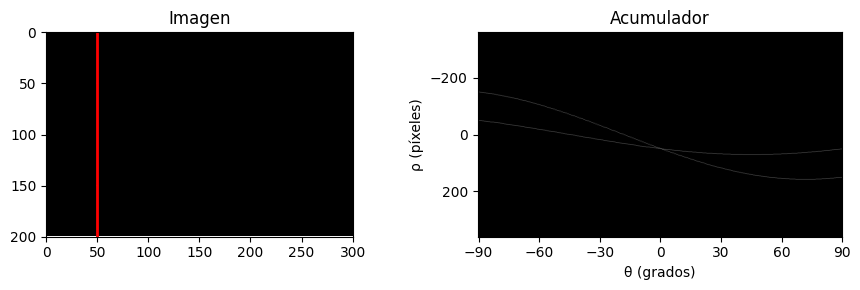

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import hough_line, hough_line_peaks

# Ejemplo 2
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]   = 255
I[150,50]  = 255

# Obtener thetas, rhos y acumulador
hspace, theta, rho = hough_line(I)

# Convertir theta a grados para el eje X
theta_deg  = np.rad2deg(theta)
angle_step = 0.5 * np.diff(theta_deg).mean()
rho_step   = 0.5 * np.diff(rho).mean()

# Definir 'extent' como [θmin, θmax, ρmin, ρmax]
extent = [
    theta_deg[0]  - angle_step,
    theta_deg[-1] + angle_step,
    rho[-1]       + rho_step,
    rho[0]        - rho_step
]

# Mostrar imagen y acumulador de Hough
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

ax[0].imshow(I, cmap='gray')
ax[0].set_title('Imagen')

ax[1].imshow(
    np.log1p(hspace),
    cmap='gray',
    aspect='auto',
    extent=extent
)
ax[1].set_title('Acumulador')
ax[1].set_xlabel('θ (grados)')
ax[1].set_xticks(np.linspace(-90, 90, 7))
ax[1].set_ylabel('ρ (píxeles)')

# Filtrar acumulador, obtener líneas y graficar
accum, angles, dists = hough_line_peaks(
    hspace, theta, rho,
    num_peaks=1
)

plot_lineas_hough(angles, dists, img_shape=I.shape, ax=ax[0])
ax[0].set_xlim((0, I.shape[1]))
ax[0].set_ylim((I.shape[0], 0))

plt.tight_layout()
plt.show()


#####Interpretación ejemplo 2

Al visualizar el acumulador, esas dos sinusoides se cruzan claramente en  θ* = 0°, ρ* = 50 px, generando un único pico dominate.

Entonces:

Para θ=0° tenemos: cos 0° = 1 y sin 0° = 0

El cálculo de la formula queda:

x⋅1 + y⋅0 = 50

Por eso la linea en el espacio de la imagen es X = 50


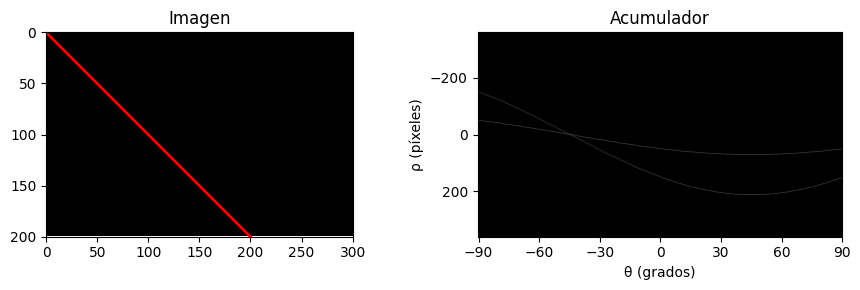

In [ ]:
#Ejemplo 3
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[150,150]=255

# Obtener thetas, rhos y acumulador
hspace, theta, rho = hough_line(I)

# Convertir theta a grados para el eje X
theta_deg  = np.rad2deg(theta)
angle_step = 0.5 * np.diff(theta_deg).mean()
rho_step   = 0.5 * np.diff(rho).mean()

# Definir 'extent' como [θmin, θmax, ρmin, ρmax]
extent = [
    theta_deg[0]  - angle_step,
    theta_deg[-1] + angle_step,
    rho[-1]       + rho_step,
    rho[0]        - rho_step
]

# Mostrar imagen y acumulador de Hough
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

ax[0].imshow(I, cmap='gray')
ax[0].set_title('Imagen')

ax[1].imshow(
    np.log1p(hspace),
    cmap='gray',
    aspect='auto',
    extent=extent
)
ax[1].set_title('Acumulador')
ax[1].set_xlabel('θ (grados)')
ax[1].set_xticks(np.linspace(-90, 90, 7))
ax[1].set_ylabel('ρ (píxeles)')

# Filtrar acumulador, obtener líneas y graficar
accum, angles, dists = hough_line_peaks(
    hspace, theta, rho,
    num_peaks=1
)

plot_lineas_hough(angles, dists, img_shape=I.shape, ax=ax[0])
ax[0].set_xlim((0, I.shape[1]))
ax[0].set_ylim((I.shape[0], 0))

plt.tight_layout()
plt.show()


#####Interpretación ejmplo 3

Cuando miramos la imagen del acumulador, esas sinusoides coinciden aproximadamente en:

θ* = -45°  y  ρ* = 0 px

Eso quiere decir, sin entrar en fórmulas, que la línea resultante:

Está inclinada 45° respecto al eje horizontal (la diagonal principal)

Pasa por el origen (porque la distancia al origen es cero)

Entonces una diagonal de 45° que atraviesa el punto (0,0) es exactamente la que cumple que por cada unidad que avanzas en x, avanzas la misma unidad en y.


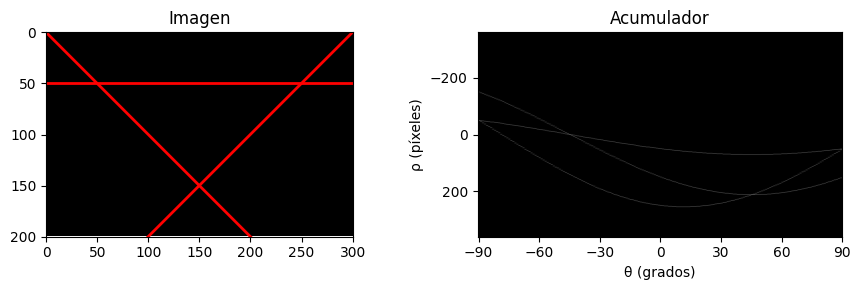

In [ ]:
# Ejemplo 4
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[50,250]=255
I[150,150]=255

# Obtener thetas, rhos y acumulador
hspace, theta, rho = hough_line(I)

# Convertir theta a grados para el eje X
theta_deg  = np.rad2deg(theta)
angle_step = 0.5 * np.diff(theta_deg).mean()
rho_step   = 0.5 * np.diff(rho).mean()

# Definir 'extent' como [θmin, θmax, ρmin, ρmax]
extent = [
    theta_deg[0]  - angle_step,
    theta_deg[-1] + angle_step,
    rho[-1]       + rho_step,
    rho[0]        - rho_step
]

# Mostrar imagen y acumulador de Hough
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

ax[0].imshow(I, cmap='gray')
ax[0].set_title('Imagen')

ax[1].imshow(
    np.log1p(hspace),
    cmap='gray',
    aspect='auto',
    extent=extent
)
ax[1].set_title('Acumulador')
ax[1].set_xlabel('θ (grados)')
ax[1].set_xticks(np.linspace(-90, 90, 7))
ax[1].set_ylabel('ρ (píxeles)')

# Filtrar acumulador, obtener líneas y graficar
accum, angles, dists = hough_line_peaks(
    hspace, theta, rho,
    num_peaks=3
)

plot_lineas_hough(angles, dists, img_shape=I.shape, ax=ax[0])
ax[0].set_xlim((0, I.shape[1]))
ax[0].set_ylim((I.shape[0], 0))

plt.tight_layout()
plt.show()



#####Interpretación: ejemplo 4
Al tener tres puntos de borde genero tres sinusoides y, por tanto, tres cruces distintos en el acumulador (cada uno indicando una de las tres rectas). Ateriormente seguía usando num_peaks=1 y solo extraíamos la horizontal más votada, pero variando num_peaks=3, extraigo los tres máximos que representan, que describen las tres rectas que cruzan los 3 puntos de la imagen.

#### Mostrar el funcionamiento de lineas_hough sobre la imagen [trapecio.png](./imagenes/trapecio.png)
Comentar resultados al variar la resolución en el espacio de parámetros (_min_distance_, _min_angle_ en la función [hough_line_peaks](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line_peaks))

In [ ]:


# ——— Bloque A: preprocesado, transformada y cálculo de extent ———

# Carga de la imagen y extracción de bordes (Canny)
ruta_imagen = os.path.join(dir_base_imagenes, 'trapecio.png')
img = imread(ruta_imagen, as_gray=True)
edges = canny(img, sigma=2)

# Cálculo de la transformada de Hough: acumulador y vectores de parámetros
hspace, theta, rho = hough_line(edges)

# Conversión de theta a grados para poder etiquetar el eje X
theta_deg = np.rad2deg(theta)

# Cálculo del “medio bin” en theta y rho para definir los bordes reales de cada celda
angle_step = 0.5 * np.diff(theta_deg).mean()
rho_step   = 0.5 * np.diff(rho).mean()

# “extent” mapea índices de hspace a valores reales [θmin, θmax, ρmin, ρmax]
extent = [
    theta_deg[0]  - angle_step,   # θ mínimo (grados)
    theta_deg[-1] + angle_step,   # θ máximo (grados)
    rho[-1]       + rho_step,     # ρ mínimo (píxeles)
    rho[0]        - rho_step      # ρ máximo (píxeles)
]

In [ ]:

# ——— Bloque B: definición de los casos de prueba ———

# Convertir 40° a número de bins para min_angle
n_bins      = len(theta)
deg_per_bin = 180.0 / n_bins
bins_40deg  = int(40.0 / deg_per_bin)

# Bloque B: definición de pruebas con umbrales claros
tests = [
    ('Default (num_peaks=10)',    {'num_peaks': 10}),
    ('min_distance=150 px',       {'num_peaks': 10, 'min_distance': 150}),
    ('min_angle=40°',             {'num_peaks': 10, 'min_angle': bins_40deg}),
    ('min_dist=150 & min_ang=40°',{'num_peaks': 10, 'min_distance': 150, 'min_angle': bins_40deg})
]



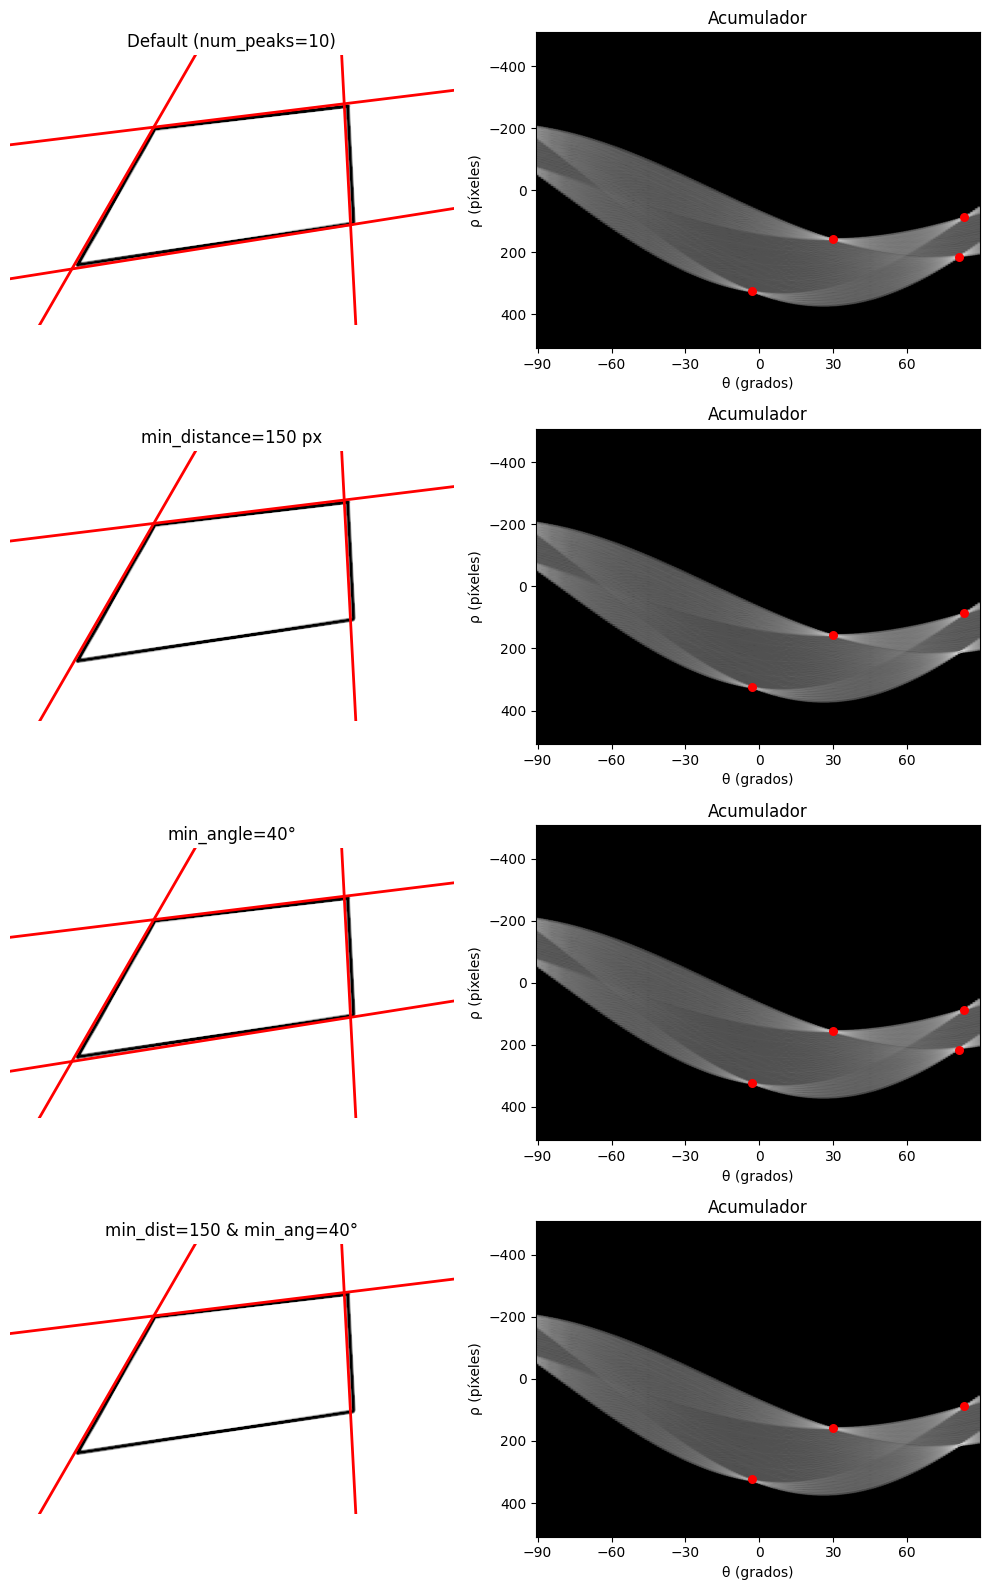

In [ ]:

# ——— Bloque C: iteración, visualización del acumulador y proyección de líneas ———

fig, axes = plt.subplots(len(tests), 2, figsize=(10, 4 * len(tests)))
for (title, params), (ax_img, ax_acc) in zip(tests, axes):
    # 1) Imagen original con líneas detectadas
    ax_img.imshow(img, cmap='gray')
    ax_img.set_title(title)
    ax_img.axis('off')

    # Extraer picos según configuración
    accum, angles, dists = hough_line_peaks(hspace, theta, rho, **params)

    # Trazar cada línea sobre la imagen usando la función ya definida
    plot_lineas_hough(angles, dists, img_shape=img.shape, ax=ax_img)
    ax_img.set_xlim((0, img.shape[1]))
    ax_img.set_ylim((img.shape[0], 0))

    # 2) Acumulador de Hough con ejes en θ (grados) y ρ (píxeles)
    ax_acc.imshow(
        np.log1p(hspace),  # escala log para visibilidad de picos bajos
        cmap='gray',
        aspect='auto',
        extent=extent
    )
    ax_acc.set_title('Acumulador')
    ax_acc.set_xlabel('θ (grados)')
    ax_acc.set_xticks(np.linspace(-90, 90, 7))
    ax_acc.set_ylabel('ρ (píxeles)')
    # Marcar en el acumulador los picos extraídos
    ax_acc.scatter(np.rad2deg(angles), dists, color='red', s=30)

plt.tight_layout()
plt.show()

#####Contexto teorico de los parametros
**min_distance** y **min_angle** son dos umbrales que regulan la resolución con la que distinguimos líneas distintas en el espacio de Hough.

**min_distance**

Es un umbral de separación a lo largo del eje ρ (la distancia al origen). Fija cuántos píxeles de diferencia(umbral) debe haber entre dos picos para tratarlos como líneas distintas. Si dos picos quedan más próximos que ese umbral en ρ, se interpretan como la misma línea y solo perdura el pico con mayor número de votos.

**min_angle**

Es un umbral de separación a lo largo del eje θ (el ángulo de la normal). Determina cuántos grados (o bins de ángulo) deben diferenciar a dos picos(umbral) para que sean contados como líneas separadas. Si dos detecciones se sitúan a menos de ese umbral en inclinación, se consideran la misma línea y solo se mantiene el pico con más votos.

En ambos casos, estamos definiendo la resolución (o granularidad) con la que distinguimos una recta “nueva” de una variante muy cercana de la misma

Con **valores bajos**, identificamos hasta cambios mínimos en posición o inclinación.

Con **valores altos**, ignoramos pequeñas variaciones y nos quedamos solo con las líneas que realmente difieren de forma apreciable.

####Comentarios acerca de los resultados: Discusión de los casos

Default (num_peaks=10)
Sin filtros, el acumulador devuelve todas las detecciones posibles: dos picos para las bases (ρ≈50 y ρ≈179), y dos para las diagonales (θ≈15° y θ≈75°). En la imagen vemos las cuatro líneas rojas sobre el trapecio.

min_distance = 150 px
Al exigir 150 píxeles de separación en ρ, los dos picos correspondientes a las bases (distintas en ρ en 130 px) caen por debajo del umbral y se fusionan en un único pico. Solo permanece la base más votada, junto con las dos diagonales.

min_angle = 40°
Con un umbral angular de 40°, las dos diagonales (separadas por 60° - 15° = 45°) sobreviven ambas, pero si el ángulo fuera menor que su diferencia real (45°), se hubieran fusionado. Aquí, justo en 40°, se filtra alguna de las diagonales menos votadas, quedando la principal. Las horizontales (cercanas a 90°) permanecen intactas.

min_distance = 150 px & min_angle = 40°
Combinando ambos umbrales, solo subsisten las dos líneas más “distantes” en el doble sentido: la base más votada (ρ≈~50) y la diagonal con diferencia angular >40° respecto a ella. Esto demuestra cómo, aplicando filtros radiales y angulares, podemos reducir las detecciones a las líneas verdaderamente significativas.

### 3. Aplicación: encontrar esquina de tableros de ajedrez

Usando lineas de Hough, determinar los vértices correspondientes a las [imágenes de tableros](./imagenes/tableros/). Comentar cómo es el procedimiento implementado y mostrar las esquinas detectadas en la imagen, junto a líneas que considere importantes.

_Se recomienda empezar con un caso sencillo, como la imagen trapecio.png, y luego seguir con los tableros._

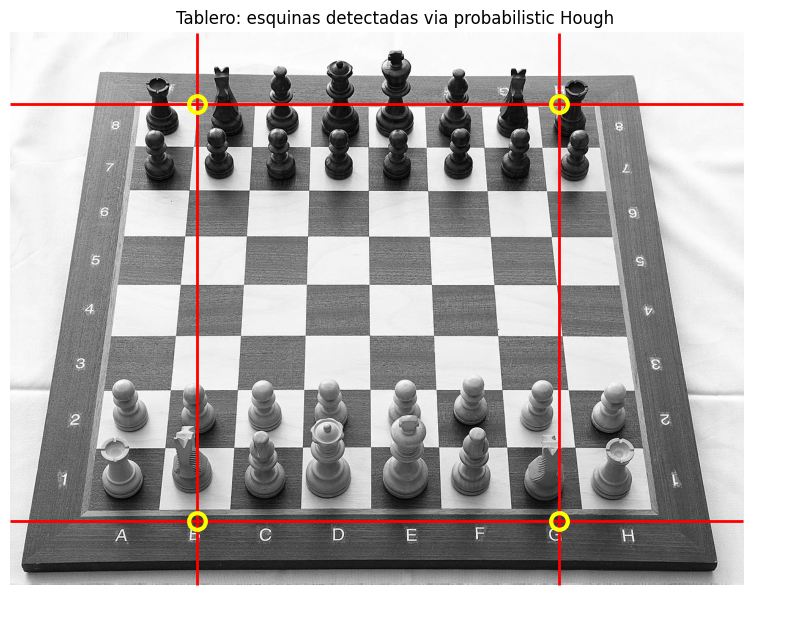

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.feature import canny
# from skimage.transform import probabilistic_hough_line
# from skimage.io import imread
# from sklearn.cluster import KMeans

# # 1) Cargar imagen y detectar bordes
# ruta_imagen = os.path.join(dir_base_imagenes, 'tableros/tablero_con_piezas_01.png')
# board = imread(ruta_imagen, as_gray=True)
# edges = canny(board, sigma=2)
# # 2) Probabilistic Hough para obtener segmentos
# segments = probabilistic_hough_line(edges,
#                                     threshold=10,
#                                     line_length=50,
#                                     line_gap=5)

# # 3) Calcular ángulos y longitudes
# angles = []
# lengths = []
# for p0, p1 in segments:
#     dy = p1[1] - p0[1]
#     dx = p1[0] - p0[0]
#     angles.append(np.rad2deg(np.arctan2(dy, dx)))
#     lengths.append(np.hypot(dx, dy))
# angles = np.array(angles)
# lengths = np.array(lengths)

# # 4) Separar segmentos horizontales y verticales
# horiz_idx = np.where(np.abs(angles) < 15)[0]
# vert_idx  = np.where(np.abs(np.abs(angles) - 90) < 15)[0]
# horiz_segs = [segments[i] for i in horiz_idx]
# vert_segs  = [segments[i] for i in vert_idx]

# # 5) Representar cada segmento por su punto medio
# horiz_mids = np.array([[(p0[0]+p1[0])/2, (p0[1]+p1[1])/2] for p0, p1 in horiz_segs])
# vert_mids  = np.array([[(p0[0]+p1[0])/2, (p0[1]+p1[1])/2] for p0, p1 in vert_segs])

# # 6) Clustering de midpoints en 2 grupos (top/bottom y left/right)
# h_km = KMeans(n_clusters=2, random_state=0).fit(horiz_mids)
# v_km = KMeans(n_clusters=2, random_state=0).fit(vert_mids)

# # 7) Obtener centro de cada cluster (representa línea límite)
# h_centers = h_km.cluster_centers_
# v_centers = v_km.cluster_centers_

# # Para horizontales: orden por y (menor y = top, mayor y = bottom)
# h_centers = sorted(h_centers, key=lambda pt: pt[1])
# top_y, bottom_y = h_centers[0][1], h_centers[1][1]

# # Para verticales: orden por x (menor x = left, mayor x = right)
# v_centers = sorted(v_centers, key=lambda pt: pt[0])
# left_x, right_x = v_centers[0][0], v_centers[1][0]

# # 8) Vértices = combinaciones de (left_x/right_x, top_y/bottom_y)
# vertices = [(left_x, top_y),
#             (right_x, top_y),
#             (left_x, bottom_y),
#             (right_x, bottom_y)]

# # 9) Visualización
# fig, ax = plt.subplots(figsize=(8,8))
# ax.imshow(board, cmap='gray')
# ax.set_title('Tablero: esquinas detectadas via probabilistic Hough')
# ax.axis('off')

# # Dibujar todos los segmentos (opcional para debug)
# # for p0, p1 in segments:
# #     ax.plot([p0[0], p1[0]], [p0[1], p1[1]], '-b', alpha=0.3)

# # Dibujar líneas límite
# # Líneas horizontales
# ax.hlines([top_y, bottom_y], xmin=0, xmax=board.shape[1], colors='red', linewidth=2)
# # Líneas verticales
# ax.vlines([left_x, right_x], ymin=0, ymax=board.shape[0], colors='red', linewidth=2)

# # Marcar esquinas
# for x, y in vertices:
#     ax.plot(x, y, 'o', ms=12, mec='yellow', mfc='none', mew=3)

# plt.tight_layout()
# plt.show()


## 5. Segmentacion de Regiones

Para este ejercicio puede ser de utilidad ejemplos de la página oficial de FIJI:

* https://imagej.net/imaging/particle-analysis
* https://imagej.net/imaging/watershed


Para imágenes de cédulas, ubicadas en la carpeta [parasitos](./imagenes/parasitos/) se quiere determinar si los núcleos estan infectados de parásitos o no. Para ello es necesario poder **identificar los núcleos y parásitos** por separado de manera automática.

<img src="./imagenes/parasitos.png" style="width:600px;" class="center">

Para que el procedimiento sea automático, deberá ajustar los parámetros en un subconjunto de imágenes representativas y variadas (en cantidad de núcleos infectados, en iluminación, etc). Una vez ajustados estos parámetros, mostrar el funcionamiento para las demás imágenes.

1. Seleccionar no más de 3 imágenes para ajustar los parámetros y ubicarlas en el directorio [_train_](./imagenes/parasitos/train/), las restantes irán a parar al directorio [_test_](./imagenes/parasitos/test/).

2. Segmentar las imagenes de _train_ y calcular las medidas necesarias (coordenadas, centroide, etc) para poder determinar, en otro procedimiento (que no se realizará en este ejercicio), cuales son los nucleos infectados. Indicar las medidas y mostrar las regiones obtenidas para este subconjunto.

Una vez elegido el procedimiento grabarlo usando la opción _Plugins --> Macros --> Record_ para reproducirlo sin necesidad de interactuar manualmente. Guardar estos pasos en una Macro de FIJI. Utilizarla en _modo batch_ sobre el directorio _test_.

3. Mostrar las segmentaciones obtenidas para los casos _train_ y _test_ y sus medidas. Comentar cualitativamente los resultados.




Intenté pero no pude hacer correr e analisis en batch para todas las imagenes. Hice varias pruebas mejorando el método, así que subí una carpeta "parasitos" dentro del directorio parasitos, que tiene un macro con el intento sobre parasitos_02.tif.